# ESRGAN training

## Setup

In [ ]:
# Get Nvidia-apex.  This takes some time.
! git clone https://github.com/NVIDIA/apex
% cd apex/
! pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
% cd ..

In [ ]:
! rm -rf ESRGAN-pytorch/

In [2]:
# Get ESRGAN-pytorch
! git clone https://github.com/qAp/ESRGAN-pytorch.git
%cd ESRGAN-pytorch/
! git checkout -b distributed remotes/origin/distributed
! pip install --editable .
%cd ../.

Cloning into 'ESRGAN-pytorch'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 889 (delta 15), reused 21 (delta 6), pack-reused 854
Receiving objects: 100% (889/889), 257.20 MiB | 33.27 MiB/s, done.
Resolving deltas: 100% (511/511), done.
/content/ESRGAN-pytorch
Branch 'distributed' set up to track remote branch 'distributed' from 'origin'.
Switched to a new branch 'distributed'
Obtaining file:///content/ESRGAN-pytorch
  Running setup.py develop for ESRGAN-pytorch-qap
/content


If you're using Colab, restart runtime now.  This is required for `pip install --editable`.

In [1]:
from google.colab import drive
import os, sys, subprocess, shutil
import collections
from pathlib import Path
import PIL, cv2
import numpy as np, scipy.misc
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def _cp(src, dst):
    assert src.is_file()
    shutil.copy(src, dst)
    
Path.cp = _cp
Path.ls = lambda o: list(o.iterdir())

In [4]:
dir_gdrive = Path('/content/drive/My Drive')

## Data

In [5]:
! cp /content/drive/My\ Drive/crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32.zip .
! unzip crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32.zip

Streaming output truncated to the last 5000 lines.
 extracting: crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/lr/1376_5.png  
 extracting: crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/lr/0345_24.png  
 extracting: crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/lr/0592_41.png  
 extracting: crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/lr/1084_3.png  
 extracting: crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/lr/0003_1.png  
 extracting: crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/lr/0342_42.png  
 extracting: crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/lr/0828_3.png  
 extracting: crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/lr/1499_33.png  
 extracting: crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/lr/0336_18.png  
 extracting: crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/lr/1694_26.png  
 extracting: crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32/lr/0794_15.png  
 extracting: crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr3

In [6]:
dir_data = Path('crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32')

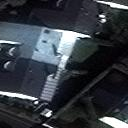

In [7]:
PIL.Image.open((dir_data/'hr').ls()[310])

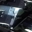

In [8]:
PIL.Image.open((dir_data/'lr').ls()[310])

## Train

### Training parameters

Some issues:  
1. The training script `main.py` cannot be executed straight, because the conda environment during the execution is NOT the same as the conda environment of the current Jupyter session.  It would execute if you go to a terminal, `conda activate` into the same conda environment as the current Jupyter session and do `python main.py` in the terminal.
2. `ArgumentParser.parse_args()` cannot be called in a Jupyter notebook apparently.  This is doable in Google Colab.

In [9]:
class Config:
    nodes = 1               # Number of nodes
    gpus = 1                # Number of GPUs per node
    nr = 0      # Node rank. If there're 2 nodes, possible node ranks are 0, 1.
    distributed = False  # Use distributed training.
    input_dir = 'datasets' # input directory, containing `hr` and `lr` directories
    load = ''  # Load model. (Default: none)
    resume = ''  # Resume model. (Default: none)
    image_size = 128  # the height / width of the input image to network
    batch_size = 16   # batch size
    sample_batch_size = 1 # sample batch size
    num_epoch = 20 # number of epochs to train for
    epoch = 0 # epochs in current train
    checkpoint_dir = 'checkpoints' # path to saved models (to continue training)
    sample_dir = 'samples' # folder to output images and model checkpoints
    workers = 5 # number of data loading workers
    scale_factor = 4 # scale factor for super resolution
    nf = 32 # number of filter in esrgan
    b1 = 0.9 # coefficients used for computing running averages of gradient and its square
    b2 = 0.999 # coefficients used for computing running averages of gradient and its square
    weight_decay = 1e-2 # weight decay
    p_lr = 2e-4 # learning rate when when training perceptual oriented
    p_decay_iter = [2e5, 2*2e5, 3*2e5, 4*2e5, 5*2e5] # Milestones of number 
    #  of mini-batches at which to halve the learning rate.
    p_content_loss_factor = 1 # content loss factor when training perceptual oriented
    p_perceptual_loss_factor = 0 # perceptual loss factor when training perceptual oriented
    p_adversarial_loss_factor = 0  # adversarial loss factor when training perceptual oriented
    g_lr = 1e-4 # learning rate when when training generator oriented
    g_decay_iter = [50000, 100000, 200000, 300000, 400000, 500000] 
    # Milestones of number of mini-batches at which to halve the learning rate.
    g_content_loss_factor = 1e-2 # content loss factor when training generator oriented
    g_perceptual_loss_factor = 1 # perceptual loss factor when training generator oriented
    g_adversarial_loss_factor = 5e-3 # adversarial loss factor when training generator oriented
    is_perceptual_oriented = True
    fp16 = False

    url = ['http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip',
           'http://cv.snu.ac.kr/research/EDSR/Flickr2K.tar'
           ]

    dataset_url = url # the url of DIV2K dataset for super resolution
    

In [10]:
config = Config()

In [11]:
# Exp 17
config.nodes = 1
config.gpus = 1
config.nr = 0
config.input_dir = dir_data
config.load = Path('/content/ESRGAN-pytorch/parameters/gan_based.pth')
config.resume = dir_gdrive/'esrgan_results'/'exp17'/'last.pth'
config.checkpoint_dir = dir_gdrive/'esrgan_results'/'exp17'
config.batch_size = 16
config.epoch = 0
config.num_epoch = 500
config.is_perceptual_oriented = False
config.scale_factor = 4

In [12]:
config.__dict__

{'batch_size': 16,
 'checkpoint_dir': PosixPath('/content/drive/My Drive/esrgan_results/exp17'),
 'epoch': 0,
 'gpus': 1,
 'input_dir': PosixPath('crops_-_well_442_spa_800_sg_500_bicubic_hr128_lr32'),
 'is_perceptual_oriented': False,
 'load': PosixPath('/content/ESRGAN-pytorch/parameters/gan_based.pth'),
 'nodes': 1,
 'nr': 0,
 'num_epoch': 500,
 'resume': PosixPath('/content/drive/My Drive/esrgan_results/exp17/last.pth'),
 'scale_factor': 4}

In [13]:
from ESRGAN_pytorch.train import train

In [ ]:
train(0, config)

Start of train(): 0
ESRGAN start
[*] Loading generator from /content/ESRGAN-pytorch/parameters/gan_based.pth
[*] Loading generator from /content/drive/My Drive/esrgan_results/exp17/last.pth
[*] Loading discriminator from /content/drive/My Drive/esrgan_results/exp17/last.pth
[*] Loading generator optmizer from /content/drive/My Drive/esrgan_results/exp17/last.pth
[*] Loading discriminator optmizer from /content/drive/My Drive/esrgan_results/exp17/last.pth
Batch size: 16. Number of nodes: 1. Each step here equates to 1 unit scheduler step in the paper.
Current unit scheduler step: 312439.
:D


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



  epoch     batch    discr.    gener.    adver.    percp.    contn.      PSNR
107:500  488:3188    0.0010    0.7095    0.0369    0.6721    0.0005   22.2031